<a href="https://colab.research.google.com/github/andreibucur1/Deep-Unrolling-Lane-Emden-Fowler/blob/main/Deep_Unrolling_Lane_Emden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt

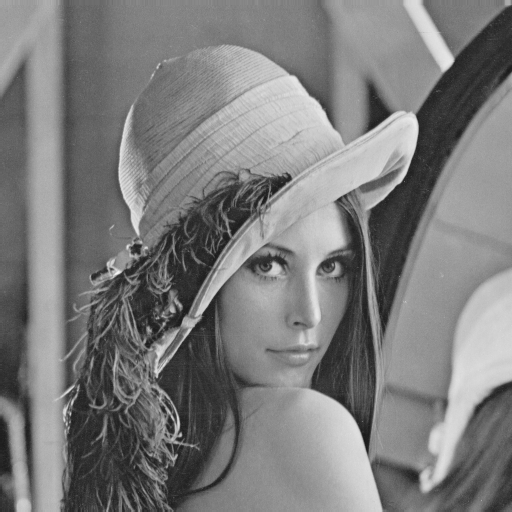

In [3]:
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"

#Wikipedia does not accept requests from python scripts, so we change the script "identity" by using
#User-Agent
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

req = urllib.request.Request(url, headers=headers)
with urllib.request.urlopen(req) as response:
    with open("lenna.png", "wb") as out_file:
        out_file.write(response.read())

#In the first phase, we will work with black and white images
img_pil = Image.open("lenna.png").convert("L")
img_pil

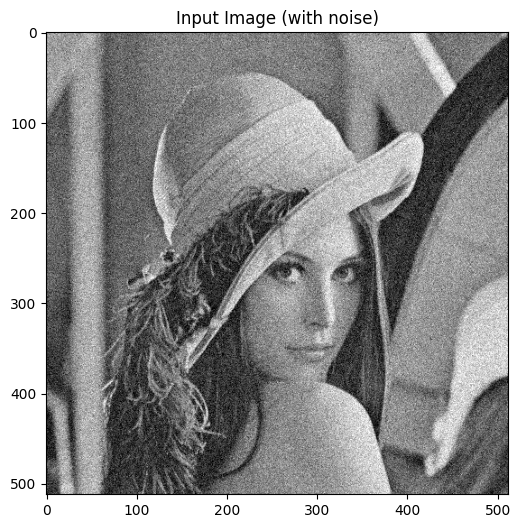

In [4]:
# NN require tensors with normalised values(between 0.0 and 1.0)
transform = transforms.ToTensor()

# apply the transformation, add a "batch" dimension (required by PyTorch), and move the data to the GPU memory (.cuda)
img_clean = transform(img_pil).unsqueeze(0).cuda()

# generate gaussian noise with StandardDeviation = 0.09
sigma = 0.09
noise = sigma * torch.randn_like(img_clean)

# add noise to the image and make sure the values are in [0.0, 1.0]
img_noisy = torch.clamp(img_clean + noise, 0.0, 1.0)

# matplotlib only works with cpu, so we bring the image from the gpu
plt.figure(figsize=(6, 6))
plt.title("Input Image (with noise)")
plt.imshow(img_noisy[0, 0].cpu().numpy(), cmap='gray')
plt.show()

In [5]:
def get_potentials(height, width, device):
  #center coordonates
  cx = width / 2.0
  cy = height / 2.0

  #generate a coordinate grid for every pixel. The "device" argument ensures this grid is built directly on the gpu
  y = torch.arange(height, device = device).float()
  x = torch.arange(width, device = device).float()
  yy, xx = torch.meshgrid(y, x, indexing='ij')

  #calculate the sqaure distance from the center for each pixel
  dist_sq = (xx - cx) ** 2 + (yy - cy) ** 2

  # spatial weight formula
  p = 1.0 / 1.0 + dist_sq

  #create a deep copy for q
  q = p.clone()

  # reshape the 2d maps (H, W) into 4d tensors (Batch, Channel, H, W)
  return p.unsqueeze(0).unsqueeze(0), q.unsqueeze(0).unsqueeze(0)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class LEFBlock(nn.Module):
    def __init__(self):
        super().__init__()

        # Declare learnable parameters
        # reaction exponents
        self.alpha = nn.Parameter(torch.tensor(0.45))
        self.beta = nn.Parameter(torch.tensor(0.35))
        # edge sensitivity threshold
        self.kappa = nn.Parameter(torch.tensor(0.14))
        # fidelity parameter
        self.lam = nn.Parameter(torch.tensor(0.12))
        # relaxation parameter
        self.omega = nn.Parameter(torch.tensor(0.78))

        # fixed smoothing kernel (calculates the cross-shaped neighborhood average)
        kernel = torch.tensor([[[[0., 1., 0.],
                                 [1., 0., 1.],
                                 [0., 1., 0.]]]]) / 4.0
        self.register_buffer("kernel_avg" , kernel)

    def forward(self, u, v, u0, p, q):
        # safety clamp to prevent NaN errors during fractional exponentiation
        u_safe = torch.clamp(u, 1e-6)
        v_safe = torch.clamp(v, 1e-6)

        # nonlinear reaction with max clipping
        N_u = torch.clamp(p * torch.pow(v_safe, self.alpha), max=0.85)
        N_v = torch.clamp(q * torch.pow(u_safe, self.beta), max=0.85)

        # calculate local average using the fixed smoothing kernel
        u_avg = F.conv2d(u, self.kernel_avg, padding=1)
        v_avg = F.conv2d(v, self.kernel_avg, padding=1)

        # pad images to handle boundary pixels during gradient computation
        u_pad = F.pad(u, (1, 1, 1, 1), mode='replicate')
        v_pad = F.pad(v, (1, 1, 1, 1), mode='replicate')

        # compute squared gradient magnitude using central differences
        gx_u = 0.5 * (u_pad[:, :, 1:-1, 2:] - u_pad[:, :, 1:-1, :-2])
        gy_u = 0.5 * (u_pad[:, :, 2:, 1:-1] - u_pad[:, :, :-2, 1:-1])
        grad_sq_u = gx_u**2 + gy_u**2

        gx_v = 0.5 * (v_pad[:, :, 1:-1, 2:] - v_pad[:, :, 1:-1, :-2])
        gy_v = 0.5 * (v_pad[:, :, 2:, 1:-1] - v_pad[:, :, :-2, 1:-1])
        grad_sq_v = gx_v**2 + gy_v**2

        # calculate Perona-Malik edge conductance
        c_edge_u = torch.exp((-1.0) * grad_sq_u / (self.kappa**2))
        c_edge_v = torch.exp((-1.0) * grad_sq_v / (self.kappa**2))

        # compute smoothed candidates
        u_smooth = u_avg + N_u / 4.0
        v_smooth = v_avg + N_v / 4.0

        # blend smoothed and original values to preserve edges
        u_cand = c_edge_u * u_smooth + (1.0 - c_edge_u) * u
        v_cand = c_edge_v * v_smooth + (1.0 - c_edge_v) * v

        # semi-implicit update with fidelity to the original noisy image
        u_new = (1.0 - self.omega) * u + self.omega * ((1.0 - self.lam) * u_cand + self.lam * u0)
        v_new = (1.0 - self.omega) * v + self.omega * ((1.0 - self.lam) * v_cand + self.lam * u0)

        return u_new, v_new

In [7]:
class LEFNet(nn.Module):
  def __init__(self, No_iterations = 5):
    super().__init__()
    self.No_iterations = No_iterations
    self.block = LEFBlock()

  def forward(self, u0, p, q):
    u = u0.clone()
    v = u0.clone()

    for _ in range(self.No_iterations):
      u, v = self.block(u, v, u0, p, q)

    return u
